# Feature Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import scipy as sc
import pandas as pd
import operator
import json

pd.options.display.max_columns = None

pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

In [2]:
match_id = 60565

with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)

roleassign_df = pd.read_csv('../data/match_{}/role_assignment_count_v2.csv'.format(match_id))
features_df = pd.read_csv('../data/match_{}/features_set.csv'.format(match_id))

## Introduction
In this document, we'll analyze various features obtained from players' $(x,y)$ coordinates and speed $|\vec{V}|$ via visualizations to see which features may be useful for predicting ball locating during the game. 

Some example data with the features we will analyze are as follows:

In [18]:
pd.options.display.float_format = '{:.5f}'.format 
features_df.head(5)

,# refX,refY,refSpeed,refDirectX,refDirectY,homeGoalKeeperX,homeGoalKeeperY,homeGoalKeeperSpeed,homeGoalKeeperDirectX,homeGoalKeeperDirectY,homeLeftBackAvgX,homeLeftBackAvgY,homeLeftBackDenisty,homeLeftBackAvgSpeed,homeLeftBackAvgDirectX,homeCenterBackSlowAvgX,homeCenterBackSlowAvgY,homeCenterBackSlowDenisity,homeCenterBackSlowAvgSpeed,homeCenterBackSlowAvgDirectX,homeCenterBackHirAvgX,homeCenterBackHirAvgY,homeCenterBackHirAvgSpeed,homeCenterBackHirAvgDirectX,homeCenterBackMaxSprintX,homeCenterBackMaxSprintY,homeCenterBackMaxSprintSpeed,homeCenterBackMaxSprintDirectX,homeCenterBackMaxSprintDirectY,homeRightBackAvgX,homeRightBackAvgY,homeRightBackDenisty,homeRightBackAvgSpeed,homeRightBackAvgDirectX,homeLeftWingerAvgX,homeLeftWingerAvgY,homeLeftWingerDenisty,homeLeftWingerAvgSpeed,homeLeftWingerAvgDirectX,homeCenterMiddleSlowAvgX,homeCenterMiddleSlowAvgY,homeCenterMiddleSlowDenisity,homeCenterMiddleSlowAvgSpeed,homeCenterMiddleSlowAvgDirectX,homeCenterMiddleHirAvgX,homeCenterMiddleHirAvgY,homeCenterMiddleHirAvgSpeed,homeCenterMiddleHirAvgDirectX,homeCenterMiddleMaxSprintX,homeCenterMiddleMaxSprintY,homeCenterMiddleMaxSprintSpeed,homeCenterMiddleMaxSprintDirectX,homeCenterMiddleMaxSprintDirectY,homeRightWingerAvgX,homeRightWingerAvgY,homeRightWingerDenisty,homeRightWingerAvgSpeed,homeRightWingerAvgDirectX,homeCenterForwardSlowAvgX,homeCenterForwardSlowAvgY,homeCenterForwardSlowDenisity,homeCenterForwardSlowAvgSpeed,homeCenterForwardSlowAvgDirectX,homeCenterForwardHirAvgX,homeCenterForwardHirAvgY,homeCenterForwardHirAvgSpeed,homeCenterForwardHirAvgDirectX,homeCenterForwardMaxSprintX,homeCenterForwardMaxSprintY,homeCenterForwardMaxSprintSpeed,homeCenterForwardMaxSprintDirectX,homeCenterForwardMaxSprintDirectY,awayGoalKeeperX,awayGoalKeeperY,awayGoalKeeperSpeed,awayGoalKeeperDirectX,awayGoalKeeperDirectY,awayLeftBackAvgX,awayLeftBackAvgY,awayLeftBackDenisty,awayLeftBackAvgSpeed,awayLeftBackAvgDirectX,awayCenterBackSlowAvgX,awayCenterBackSlowAvgY,awayCenterBackSlowDenisity,awayCenterBackSlowAvgSpeed,awayCenterBackSlowAvgDirectX,awayCenterBackHirAvgX,awayCenterBackHirAvgY,awayCenterBackHirAvgSpeed,awayCenterBackHirAvgDirectX,awayCenterBackMaxSprintX,awayCenterBackMaxSprintY,awayCenterBackMaxSprintSpeed,awayCenterBackMaxSprintDirectX,awayCenterBackMaxSprintDirectY,awayRightBackAvgX,awayRightBackAvgY,awayRightBackDenisty,awayRightBackAvgSpeed,awayRightBackAvgDirectX,awayLeftWingerAvgX,awayLeftWingerAvgY,awayLeftWingerDenisty,awayLeftWingerAvgSpeed,awayLeftWingerAvgDirectX,awayCenterMiddleSlowAvgX,awayCenterMiddleSlowAvgY,awayCenterMiddleSlowDenisity,awayCenterMiddleSlowAvgSpeed,awayCenterMiddleSlowAvgDirectX,awayCenterMiddleHirAvgX,awayCenterMiddleHirAvgY,awayCenterMiddleHirAvgSpeed,awayCenterMiddleHirAvgDirectX,awayCenterMiddleMaxSprintX,awayCenterMiddleMaxSprintY,awayCenterMiddleMaxSprintSpeed,awayCenterMiddleMaxSprintDirectX,awayCenterMiddleMaxSprintDirectY,awayRightWingerAvgX,awayRightWingerAvgY,awayRightWingerDenisty,awayRightWingerAvgSpeed,awayRightWingerAvgDirectX,awayCenterForwardSlowAvgX,awayCenterForwardSlowAvgY,awayCenterForwardSlowDenisity,awayCenterForwardSlowAvgSpeed,awayCenterForwardSlowAvgDirectX,awayCenterForwardHirAvgX,awayCenterForwardHirAvgY,awayCenterForwardHirAvgSpeed,awayCenterForwardHirAvgDirectX,awayCenterForwardMaxSprintX,awayCenterForwardMaxSprintY,awayCenterForwardMaxSprintSpeed,awayCenterForwardMaxSprintDirectX,awayCenterForwardMaxSprintDirectY,pitch_index
0,73.38000,38.94000,2.53000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,68.81000,23.42000,1.00000,4.28000,1.00000,53.13000,25.97000,1.00000,1.08000,53.13000,0.00000,0.00000,0.00000,0.00000,75.99000,47.51000,4.92000,1.00000,1.00000,56.58000,53.98000,1.00000,3.29000,1.00000,84.64000,24.69000,1.00000,2.65000,1.00000,88.11000,32.53000,1.00000,1.20000,88.11000,66.56000,39.03000,1.55000,66.56000,0.00000,0.00000,0.00000,0.00000,0.00000,78.73000,51.32000,1.00000,1.14000,1.00000,85.78000,35.11000,1.00000,0.49000,85.78000,0.00000,0.00000,2.55000,0.0000

## Role assignment analysis

Role assignment is important standpoint in our project. Our approach is role based, rather than using each player's various data, we group them to different roles based on their average positions for past timeline of 15 minutes, then use these group features; such as average coordinate and seed of group, fastest player coordinate and seed in the group, for predicting player location. [Here is](scale_roleassign_visualization.ipynb) is more detailed information on how to do arole assignment.

We have folowing roles:

In [30]:
role_dict = {
    0: 'LeftBack',
    1: 'CenterBack',
    2: 'RightBack',
    3: 'LeftWinger',
    4: 'CenterMiddle',
    5: 'RightWinger',
    6: 'CenterForward'
}

Some example data with the role assigment frame we will analyze are as follows:

In [19]:
pd.options.display.float_format = '{:.0f}'.format 
roleassign_df.head(5)

,# matchId,half,min,sec,homeLeftBack,homeCenterBack,homeRightBack,homeLeftWinger,homeCenterMiddle,homeRightWinger,homeCenterForward,awayLeftBack,awayCenterBack,awayRightBack,awayLeftWinger,awayCenterMiddle,awayRightWinger,awayCenterForward
0,60565,1,2,0,1,2,1,1,2,1,2,0,1,1,2,2,2,2
1,60565,1,2,1,1,2,1,1,2,1,2,0,2,0,2,2,2,2
2,60565,1,2,2,1,2,1,1,2,1,2,0,2,0,2,2,2,2
3,60565,1,2,3,1,2,1,1,2,1,2,0,2,0,2,2,2,2
4,60565,1,2,4,1,2,1,1,2,1,2,0,2,0,2,2,2,2


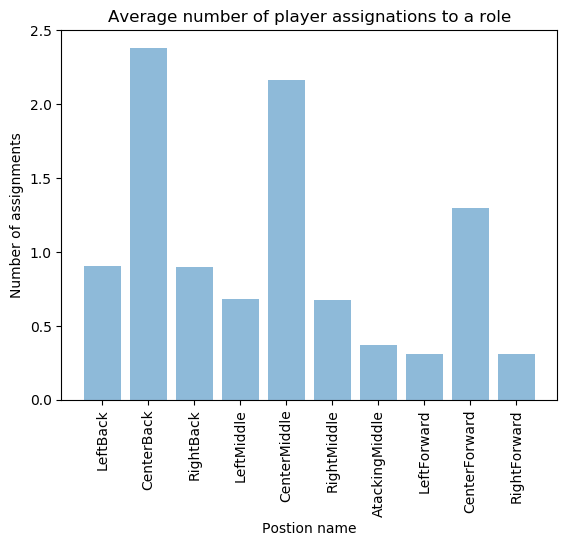

In [36]:
# previous role dictionary
role_dict2 = {
    0: 'LeftBack',
    1: 'CenterBack',
    2: 'RightBack',
    3: 'LeftMiddle',
    4: 'CenterMiddle',
    5: 'RightMiddle',
    6: 'AtackingMiddle',
    7: 'LeftForward',
    8: 'CenterForward',
    9: 'RightForward'
}

def plot_players_assignments(role_dict, source):
    role_rng = len(role_dict)
    role_assignment_count = np.zeros(shape=(role_rng), dtype=np.float)
    match_count = 0

    # reading through the all matches
    for match_data in matches:
        match_id = int(match_data['id'])
        try:
            roleassign_df = pd.read_csv(source.format(match_id))
            for i in range(0,role_rng):
                role_assignment_count[i] += (roleassign_df['home'+ role_dict[i]].sum(axis=0)+ roleassign_df['away'+ role_dict[i]].sum(axis=0))
            match_count+=1
        except FileNotFoundError:
            pass

    for i in range(0,role_rng):
        role_assignment_count[i] = role_assignment_count[i]/(match_count*2*5000)

    label=[]
    for i in range(0,role_rng):
        label.append(role_dict[i])

    y_pos = np.arange(len(label))
    plt.bar(y_pos, role_assignment_count, align='center', alpha=0.5)
    plt.xticks(y_pos, label, rotation='vertical')
    plt.ylabel('Number of assignments')
    plt.xlabel('Postion name')
    plt.title('Average number of player assignations to a role')
    plt.show()
    
plot_players_assignments(role_dict2, source='../data/match_{}/role_assignment_count.csv')

In the above diagram, we can see that Center Back, Center Middle, and Center Forward are the most dominant positions to which players were assigned most. This can be explained with that football matches are generally more concentrated to the center of the pitch. Although Center Forward is among the most assigned position but is only makes about half of the Center Back and Center Middle. We can also categorize Left Back and Right Back as common roles as they are just slightly below Center Forwad, between 2 and 1 assignation to each.<br>
<br>The number of other positions (Left Forward, Right Forward, Atacking Middle) assignation is low compared to 3 major role. That means, their groups features set completely equal to zero most of the time, so that can cause some noise while building a predictive model.

### What can we do about this problem?

#### 1. Combine alike roles together

We can combine less occurred roles together with the most assigned roles of the same category and can me some adjusment on segments borders.
For example, Left Forward and Right Forward are least assigned categories, oppositely the Center Forward is one of the common.<br>
New Combination:
* *Left Back* (0,40,0,19)
* *Center Back* (0,35,19,49)
* *Right Back* (0,40,49,68)
* *Center Middle* (35,75,49,68)
* *Left Middle (+Left Forward)* (40,105,0,19)
* *Center Forward (+Atacking Middle)* (75,105,19,49)
* *Right Middle (+Right Middle)* (40,105,49,68)

From the bar chart shown above, we can easily understand that the number of players assigned to each position during the whole match. Therefore, we can identify specific position which generally occupied by only one player and them reduce the number of extra features calculated for this area.

Average number of player assignations after modification:

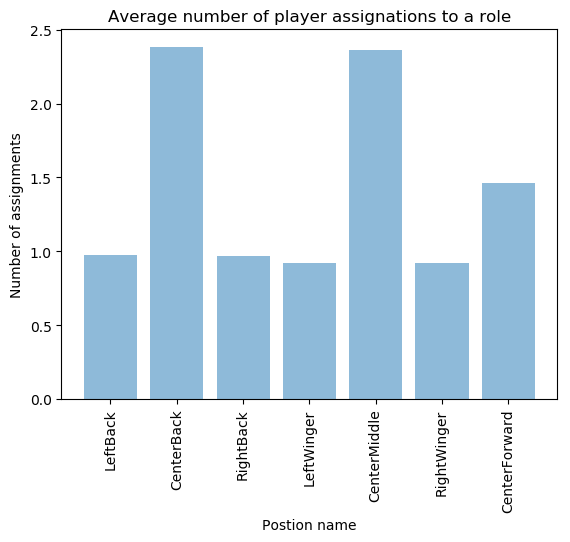

In [37]:
plot_players_assignments(role_dict, source='../data/match_{}/role_assignment_count_v2.csv')

After modification, it seems that on average every position segment has at least 1 player assignation in each distinct frame. Also, the assignation number of side (1) and center (2-3 in general) positions are as we expected. Based on this diagram, while building the features set, our approach to a side position as a single player and to a center as a group featured seems reasonably okay.

## Histogram Analysis of Various Features

In this section, we'll plot histograms about some features to generalize the data we have by feature construction.<br>

### Center  Group players

Center group is consist of Center Back, Center Middlefield, and Center Forward player groups.

In [3]:
try:
    features_df = pd.read_csv('../data/match_{}/features_set_v2.csv'.format(match_id))
except FileNotFoundError:
    pass

def plot_hist(cols, title):
    plt.figure(figsize=(13, 8))
    for col, (raw, header) in cols.items():
        plt.subplot(2, 2, col)
        raw = np.array(raw)
        plt.xlabel('Horizontal (m)')
        plt.ylabel('Vertical (m)')
        plt.hist2d((raw[:,0]), (raw[:,1]), cmap='hot', bins=(32)) 
        plt.title(header+title)
        plt.colorbar()
    plt.tight_layout()

In [255]:
def get_location_info(main_pos_status, t_small, t_big, x_pos, y_pos, group_v, group_h, group_s, list_v, list_h, list_s, ball_cord):
    
    if main_pos_status==0:
        threshold_raw = x_pos
    else:
        threshold_raw = y_pos
        
    for frame in range(0, len(features_df)):
        p_index = pith_index[frame]
        if threshold_raw[frame]!=0 and p_index !=0:
            if threshold_raw[frame]>=t_small and threshold_raw[frame]<=t_big:
                ball_cord.append([x_pos[frame], y_pos[frame]])
                if group_v[0][frame]!=0:
                    list_v.append([group_v[0][frame], group_v[1][frame]])
                if group_h[0][frame]!=0:
                    list_h.append([group_h[0][frame], group_h[1][frame]])
                if group_s[0][frame]!=0:
                    list_s.append([group_s[0][frame], group_s[1][frame]])

    list_v.append([105,60])
    list_v.append([0,0])
    list_h.append([105,60])
    list_h.append([0,0])
    list_s.append([105,60])
    list_s.append([0,0])
    ball_cord.append([105,60])
    ball_cord.append([0,0]) 


# center-back slow group avrg player position
cb_slow_avg_cord = []
cb_hir_avg_cord = []
cb_sprint_avg_cord = []
cb_actual_ball_cord = []

# forward players
f_slow_avg_cord = []
f_hir_avg_cord = []
f_sprint_avg_cord = []
f_actual_ball_cord = []


# center middlefielders players
cm_slow_avg_cord = []
cm_hir_avg_cord = []
cm_sprint_avg_cord = []
cm_actual_ball_cord = []

cb_slow = [features_df['homeCenterBackSlowAvgX'], features_df['homeCenterBackSlowAvgY']]
cb_hir = [features_df['homeCenterBackHirAvgX'], features_df['homeCenterBackHirAvgY']]
cb_sprint = [features_df['homeCenterBackMaxSprintX'], features_df['homeCenterBackMaxSprintY']]

f_slow = [features_df['homeCenterForwardSlowAvgX'], features_df['homeCenterForwardSlowAvgY']]
f_hir = [features_df['homeCenterForwardHirAvgX'], features_df['homeCenterForwardHirAvgY']]
f_sprint = [features_df['homeCenterForwardMaxSprintX'], features_df['homeCenterForwardMaxSprintY']]

cm_slow = [features_df['homeCenterMiddleSlowAvgX'], features_df['homeCenterMiddleSlowAvgY']]
cm_hir = [features_df['homeCenterMiddleHirAvgX'], features_df['homeCenterMiddleHirAvgY']]
cm_sprint = [features_df['homeCenterMiddleMaxSprintX'], features_df['homeCenterMiddleMaxSprintY']]


group_x = features_df['homeCenterBackSlowAvgX']
group_y = features_df['homeCenterBackSlowAvgY']
x_pos = features_df['xpos']
y_pos = features_df['ypos']
pith_index = features_df['pitch_index']


get_location_info(0, 0, 50, x_pos, y_pos, cb_slow, cb_hir, cb_sprint, 
                  cb_slow_avg_cord, cb_hir_avg_cord, cb_sprint_avg_cord, cb_actual_ball_cord)

get_location_info(0, 50, 105, x_pos, y_pos, f_slow, f_hir, f_sprint, 
                  f_slow_avg_cord, f_hir_avg_cord, f_sprint_avg_cord, f_actual_ball_cord)

get_location_info(0, 35, 75, x_pos, y_pos, cm_slow, cm_hir, cm_sprint, 
                  cm_slow_avg_cord, cm_hir_avg_cord, cm_sprint_avg_cord, cm_actual_ball_cord)


cols_cb = {
    1 : (cb_slow_avg_cord, 'Center-back SLOW avg pos'),
    2 : (cb_hir_avg_cord, 'Center-back HIR avg pos'),
    3 : (cb_sprint_avg_cord, 'Center-back max-SPRINT pos'),
    4 : (cb_actual_ball_cord, 'Ball itself')
}

cols_f = {
    1 : (f_slow_avg_cord, 'Center-forward SLOW avg pos'),
    2 : (f_hir_avg_cord, 'Center-forward HIR avg pos'),
    3 : (f_sprint_avg_cord, 'Center-forward max-SPRINT pos'),
    4 : (f_actual_ball_cord, 'Ball itself')
}

cols_cm = {
    1 : (cm_slow_avg_cord, 'Center-middle SLOW avg pos'),
    2 : (cm_hir_avg_cord, 'Center-middle HIR avg pos'),
    3 : (cm_sprint_avg_cord, 'Center-middle max-SPRINT pos'),
    4 : (cm_actual_ball_cord, 'Ball itself')
}

#### *i. Center Defence*
Histogram for SLOW, HIR, Max-SPRINT player groups.

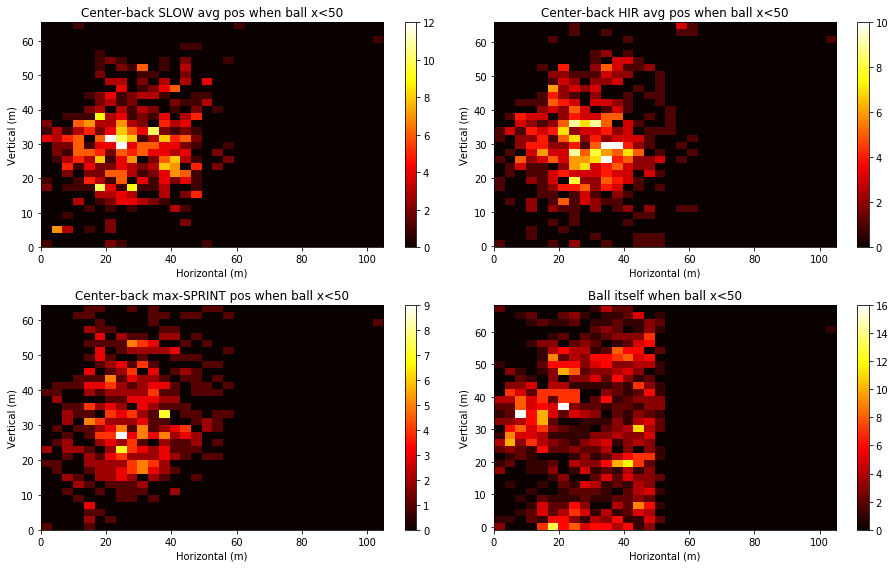

In [256]:
plot_hist(cols_cb, ' when ball x<50')

#### *ii. Center Middlefielders*
Histogram for SLOW, HIR, Max-SPRINT player groups.

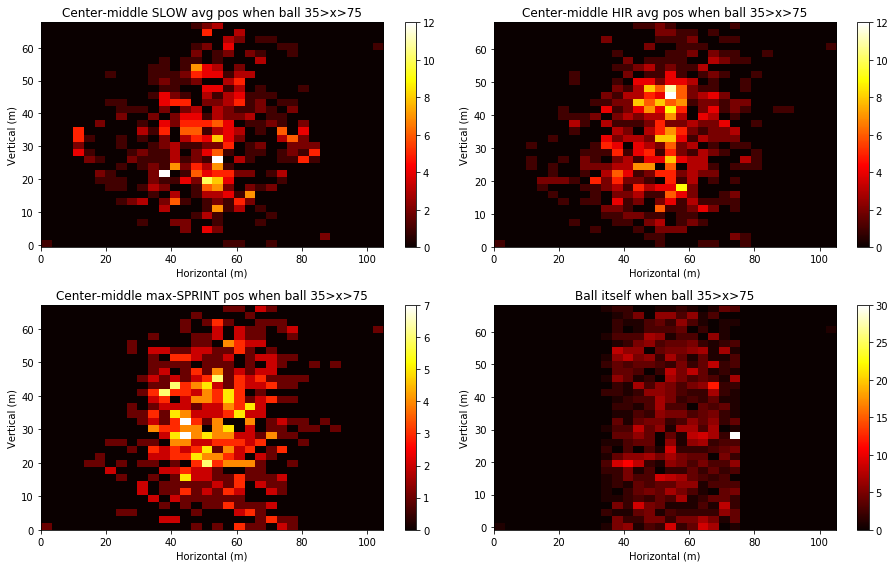

In [257]:
plot_hist(cols_cm, ' when ball 35>x>75')

#### *iii. Center Forward*
Histogram for SLOW, HIR, Max-SPRINT player groups.

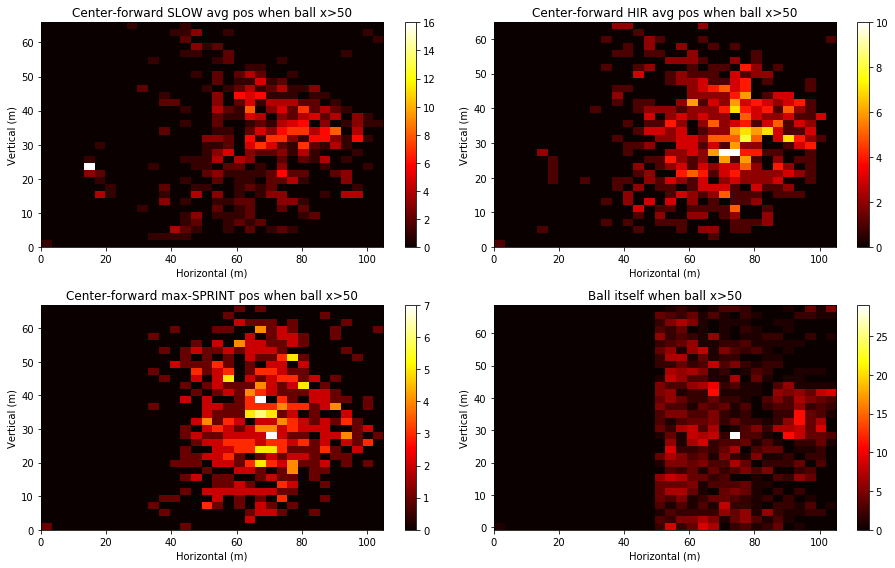

In [280]:
plot_hist(cols_f, ' when ball x>50')

### Winger  Group player

Winger group is consist of Left Back, Right Back, Left Winger and Right Winger player groups.

In [298]:
def get_location_info_winger(xt_small, xt_big, yt_small, yt_big, x_pos, y_pos, group, group_list, ball_cord):

    for frame in range(0, len(features_df)):
        p_index = pith_index[frame]
        if x_pos[frame]!=0 and p_index !=0:
            if x_pos[frame]>=xt_small and x_pos[frame]<=xt_big and y_pos[frame]>=yt_small and y_pos[frame]<=yt_big:
                ball_cord.append([x_pos[frame], y_pos[frame]])
                if group[0][frame]!=0:
                    group_list.append([group[0][frame], group[1][frame]])

    group_list.append([105,60])
    group_list.append([0,0])
    ball_cord.append([105,60])
    ball_cord.append([0,0])

    
    
lb_avg_cord = [] # left back
lb_ball_cord= []
lw_avg_cord = [] # left winger
lw_ball_cord= []
rb_avg_cord = [] # right back
rb_ball_cord= []
rw_avg_cord = [] # right winger
rw_ball_cord= []

lb_cords = [features_df['homeLeftBackAvgX'], features_df['homeLeftBackAvgY']]
lw_cords = [features_df['homeLeftWingerAvgX'], features_df['homeLeftWingerAvgY']]
rb_cords = [features_df['homeRightBackAvgX'], features_df['homeRightBackAvgY']]
rw_cords = [features_df['homeRightWingerAvgX'], features_df['homeRightWingerAvgY']]
    
get_location_info_winger(0,45,0,34,   x_pos, y_pos, lb_cords, lb_avg_cord, lb_ball_cord) # left back
get_location_info_winger(45,105,0,34, x_pos, y_pos, lw_cords, lw_avg_cord, lw_ball_cord) # left winger
get_location_info_winger(0,45,34,68,  x_pos, y_pos, rb_cords, rb_avg_cord, rb_ball_cord) # right back
get_location_info_winger(45,105,34,68,x_pos, y_pos, rw_cords, rw_avg_cord, rw_ball_cord) # right winger

cols_lb = {
    1 : (lb_avg_cord,  'Left-back avg pos'),
    2 : (lb_ball_cord, 'Ball itself')
}

cols_lw = {
    1 : (lw_avg_cord,  'Left-winger avg pos'),
    2 : (lw_ball_cord, 'Ball itself')
}

cols_rb = {
    1 : (rb_avg_cord,  'Right-back avg pos'),
    2 : (rb_ball_cord, 'Ball itself')
}

cols_rw = {
    1 : (rw_avg_cord,  'Right-winger avg pos'),
    2 : (rw_ball_cord, 'Ball itself')
}  

#### *i. Left Back*
Average pisition of left-back player group

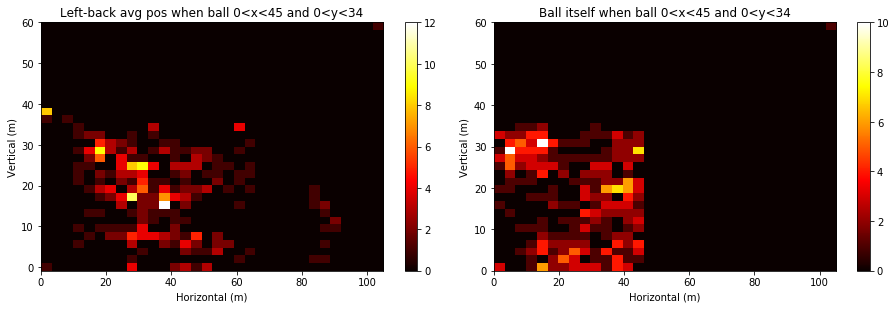

In [304]:
plot_hist(cols_lb, ' when ball 0<x<45 and 0<y<34')

#### *ii. Right Back*
Average pisition of right-back player group

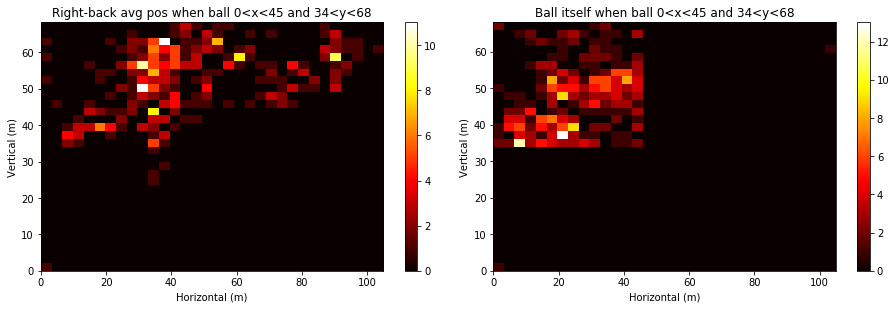

In [300]:
plot_hist(cols_rb, ' when ball 0<x<45 and 34<y<68')

#### *iii. Left Winger*
Average pisition of left-winger player group

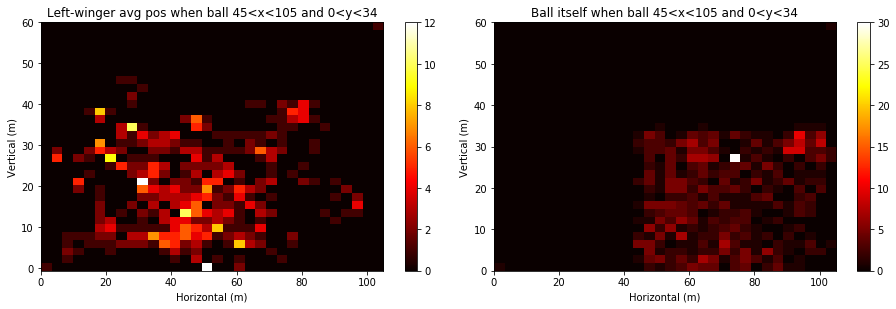

In [302]:
plot_hist(cols_lw, ' when ball 45<x<105 and 0<y<34')

#### *iv. Right Winger*
Average pisition of right-winger player group

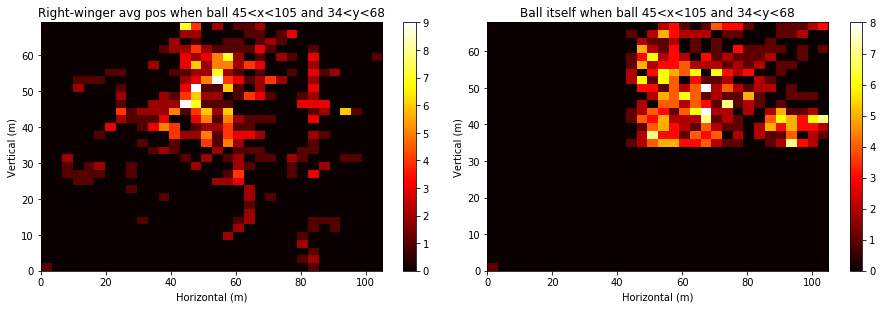

In [303]:
plot_hist(cols_rw, ' when ball 45<x<105 and 34<y<68')

### Referee Position for Ball Location Detection

Referees is one of the most importan figures in the soccer match, he/she oftentimes stands next to the player beind the ball in order to watch for fouls occurring. So their position, both $x,y$ coordinates, can be used for ball location detection. 

In [136]:
def define_pitch_index(x,y):
    Xi=x//5
    if y<=60:
        Yj = y//5+1
    elif y<=64:
        Yj = 13
    else:
        Yj = 14
    if Xi==21:
        Xi-=1
    index = Xi*14 + Yj
    return index

referee_cord = [features_df['# refX'], features_df['refY']]
ball_cord = [features_df['xpos'], features_df['ypos']]
pith_index = features_df['pitch_index']

referee_cord_l = []
ball_cord_l = []
referee_index = []
ball_index = []

for frame in range(0, len(features_df)):
    p_index = pith_index[frame]
    if ball_cord[0][frame]!=0 and p_index !=0:
        ball_index.append([p_index])
        referee_index.append([define_pitch_index(referee_cord[0][frame], referee_cord[1][frame])])
        referee_cord_l.append([referee_cord[0][frame], referee_cord[1][frame]])
        ball_cord_l.append([ball_cord[0][frame], ball_cord[1][frame]])
        
referee_cord_l = np.array(referee_cord_l)
ball_cord_l = np.array(ball_cord_l)
referee_index = np.array(referee_index)
ball_index = np.array(ball_index)

#### *i. Referee and Ball (x,y) cords*

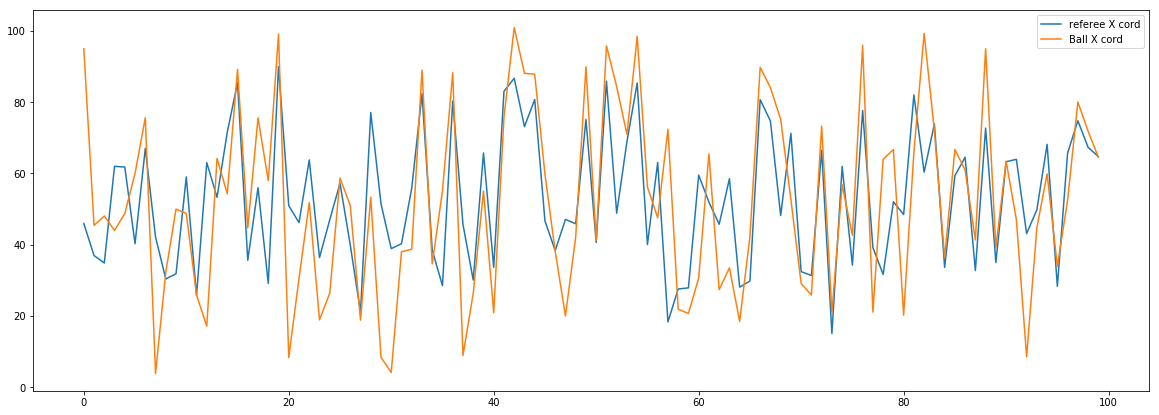

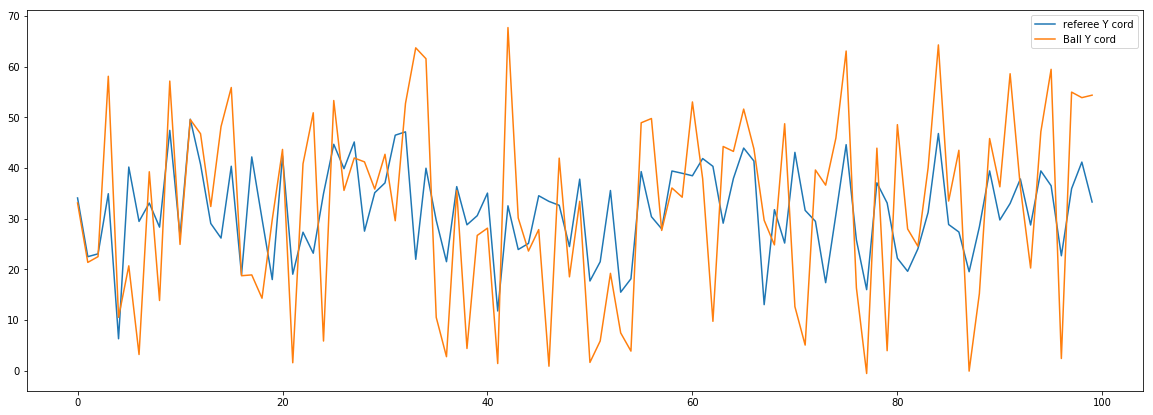

In [137]:
referee_x = np.array(referee_cord_l[:,0])
referee_y = np.array(referee_cord_l[:,1])
ball_x = np.array(ball_cord_l[:,0])
ball_y = np.array(ball_cord_l[:,1])
referee_idx  = np.array(referee_index[:,0])
ball_idx  = np.array(ball_index[:,0])

idx = np.random.choice(np.arange(len(referee_cord_l)), 100, replace=False)
referee_x = referee_x[idx]
referee_y = referee_y[idx]
ball_x = ball_x[idx]
ball_y = ball_y[idx]
referee_idx = referee_idx[idx]
ball_idx = ball_idx[idx]

df = pd.DataFrame({
'referee X cord': referee_x,
'referee Y cord': referee_y,
'Ball X cord': ball_x,
'Ball Y cord': ball_y
})

plt.figure(figsize=(20,7))
df[['referee X cord', 'Ball X cord']].plot(ax = plt.gca())
plt.show()
plt.figure(figsize=(20,7))
df[['referee Y cord', 'Ball Y cord']].plot(ax = plt.gca())
plt.show()

#### *ii. Referee and Ball location segments (index)*

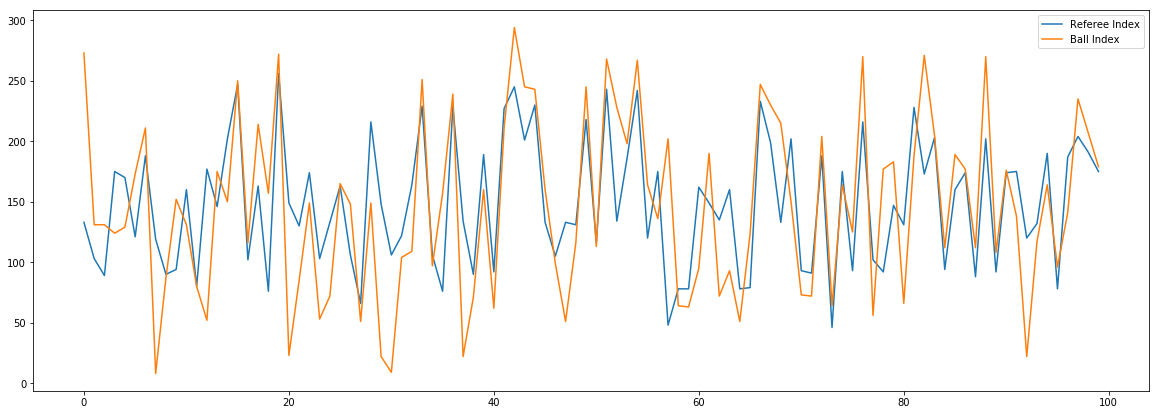

In [153]:
df2 = pd.DataFrame({
'Referee Index': referee_idx,
'Ball Index': ball_idx
})

plt.figure(figsize=(20,7))
df2[['Referee Index', 'Ball Index']].plot(ax = plt.gca())
plt.show()

### Center Grups Speed Anaylsis

In [274]:
def initialize_data(x1,x2,y1,y2, group_data, ball_cord, pith_index):
    # x1,x2,y1,y2 for ball location
    group_cord_l = []
    ball_index = []
    for frame in range(0, len(features_df)):
        p_index = pitch_index[frame]
        if ball_cord[0][frame]!=0 and ball_cord[0][frame]>=x1 and ball_cord[0][frame]<=x2 and ball_cord[1][frame]>=y1 and ball_cord[1][frame]<=y2 and p_index !=0 and group_data[0][frame]!=0:
            group_cord_l.append([define_pitch_index(group_data[0][frame], group_data[1][frame])])
            ball_index.append([p_index])

    
    group_cord_l = np.array(group_cord_l)
    ball_index = np.array(ball_index)

    return group_cord_l, ball_index

cb_max_cord = [features_df['homeCenterMiddleMaxSprintX'], features_df['homeCenterMiddleMaxSprintY']]
cb_hir_cord = [features_df['homeCenterMiddleHirAvgX'], features_df['homeCenterMiddleHirAvgY']]
cb_slow_cord = [features_df['homeCenterMiddleSlowAvgX'], features_df['homeCenterMiddleSlowAvgY']]

ball_cord = [features_df['xpos'], features_df['ypos']]
pitch_index = features_df['pitch_index']

cm_max_cord_l, cm_max_ball_cord_l =  initialize_data(35,75,14,54, cb_max_cord, ball_cord, pitch_index)
cm_hir_cord_l, cm_hir_ball_cord_l =  initialize_data(35,75,14,54, cb_hir_cord, ball_cord, pitch_index)
cm_slow_cord_l,cm_slow_ball_cord_l =  initialize_data(35,75,14,54, cb_slow_cord, ball_cord, pitch_index)

df = pd.DataFrame({
'Center-Middle normal X segment': cm_slow_cord_l[:,0],
'Ball X segment': cm_slow_ball_cord_l[:,0],  
})

df1 = pd.DataFrame({
'Center-Middle Hir X segment': cm_hir_cord_l[:,0],
'Ball X segment during Hir': cm_hir_ball_cord_l[:,0],  
})


df2 = pd.DataFrame({
'Center-Middle max-Sprint X segment': cm_max_cord_l[:,0],
'Ball X segment during max-Sprint': cm_max_ball_cord_l[:,0],  
})

#### *i. Forward Slow players*

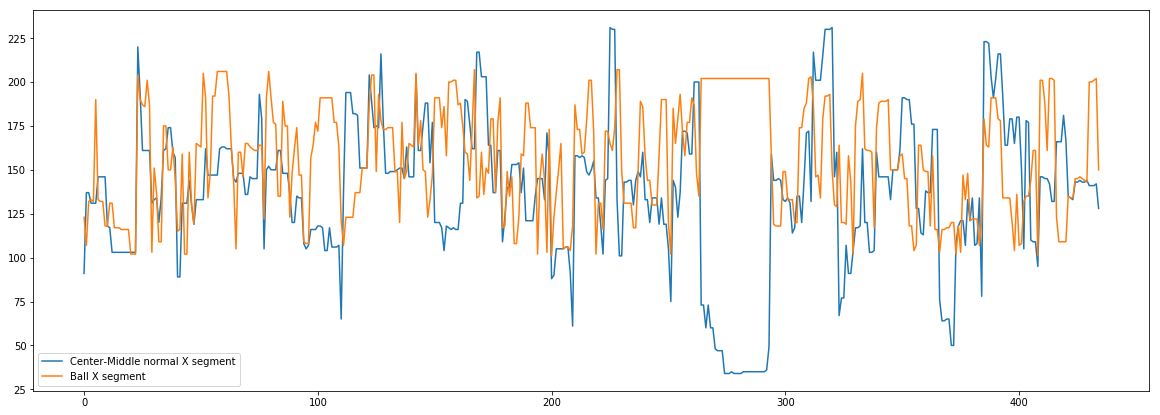

In [275]:
plt.figure(figsize=(20,7))
df[['Center-Middle normal X segment', 'Ball X segment']].plot(ax = plt.gca())
plt.show()

#### *ii. Forward HIR $(1.5<\vec{V}_{hir}<3)$ players*

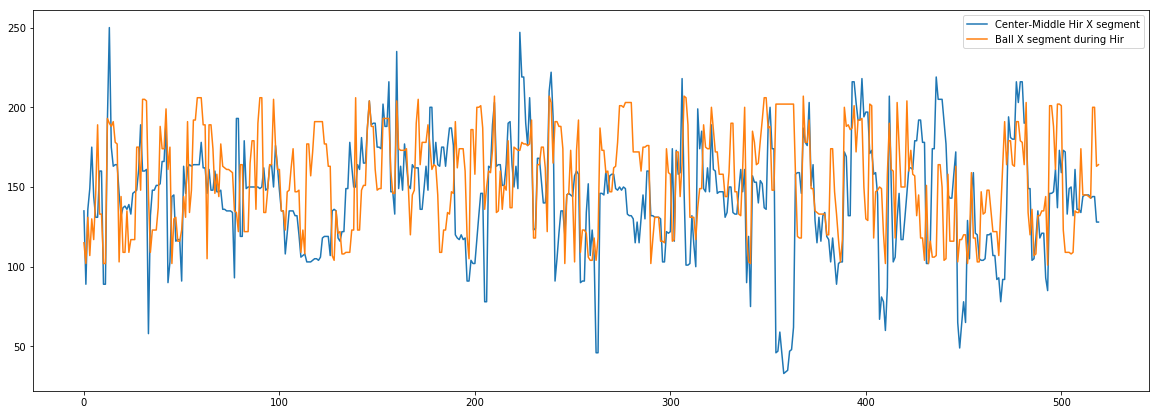

In [276]:
plt.figure(figsize=(20,7))
df1[['Center-Middle Hir X segment', 'Ball X segment during Hir']].plot(ax = plt.gca())
plt.show()

#### *iii. Forward max-Sprint $max(\vec{V}_{sprint}>3)$ players*

In [ ]:
plt.figure(figsize=(20,7))
df2[['Center-Middle max-Sprint X segment', 'Ball X segment during max-Sprint']].plot(ax = plt.gca())
plt.show()